In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [23]:
hotels=pd.read_csv("C:/ACL/archive/hotels.csv")
reviews=pd.read_csv("C:/ACL/archive/reviews.csv")
users=pd.read_csv("C:/ACL/archive/users.csv")

In [24]:
print(f"Hotels duplicates: {hotels.duplicated().sum()}")
print(f"Reviews duplicates: {reviews.duplicated().sum()}")
print(f"Users duplicates: {users.duplicated().sum()}")
print("--------------------------------")
print(f"Hotels nuls: {hotels.isnull().sum()}")
print("--------------------------------")
print(f"Reviews nuls: {reviews.isnull().sum()}")
print("--------------------------------")
print(f"Users nuls: {users.isnull().sum()}")

Hotels duplicates: 0
Reviews duplicates: 0
Users duplicates: 0
--------------------------------
Hotels nuls: hotel_id                0
hotel_name              0
city                    0
country                 0
star_rating             0
lat                     0
lon                     0
cleanliness_base        0
comfort_base            0
facilities_base         0
location_base           0
staff_base              0
value_for_money_base    0
dtype: int64
--------------------------------
Reviews nuls: review_id                0
user_id                  0
hotel_id                 0
review_date              0
score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
review_text              0
dtype: int64
--------------------------------
Users nuls: user_id           0
user_gender       0
country           0
age_group         0
traveller_type    0
join_date  

In [25]:
reviews.info()
print("--------------------------------")   
hotels.info()
print("--------------------------------")
users.info()
print("--------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              50000 non-null  int64  
 1   user_id                50000 non-null  int64  
 2   hotel_id               50000 non-null  int64  
 3   review_date            50000 non-null  object 
 4   score_overall          50000 non-null  float64
 5   score_cleanliness      50000 non-null  float64
 6   score_comfort          50000 non-null  float64
 7   score_facilities       50000 non-null  float64
 8   score_location         50000 non-null  float64
 9   score_staff            50000 non-null  float64
 10  score_value_for_money  50000 non-null  float64
 11  review_text            50000 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 4.6+ MB
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 2

This code merges the reviews, hotels, and users datasets into one DataFrame (df) by performing left joins on the hotel_id and user_id columns to combine review, hotel, and user information.

In [26]:
review_hotel_df=reviews.merge(hotels,on='hotel_id',how='left')
df=review_hotel_df.merge(users,on='user_id',how='left')

After merging the hotels and users tables, the duplicate "country" columns were renamed to improve clarity: country_x (from hotels) became hotel_country, and country_y (from users) became user_country.

In [27]:
df.rename(columns={"country_x":"hotel_country","country_y":"user_country"},inplace=True)

The code assigns users' countries to geographic regions using a dictionary of regions and their countries. It adds a 'country_group' column with apply(), labeling unmatched countries as 'Other'

In [28]:
groups={'North_America':['United States','Canada'],
        'Western_Europe':['Germany','France','United Kingdom','Netherlands','Spain','Italy'],
        'Eastern_Europe':['Russia'],
        'East_Asia':['China','Japan','South Korea'],
        'Southeast_Asia':['Thailand','Singapore'],
        'Middle_East':['United Arab Emirates','Turkey'],
        'Africa':['Egypt','Nigeria','South Africa'],
        'Oceania':['Australia','New Zealand'],
        'South_America':['Brazil','Argentina'],
        'South_Asia':['India'],
        'North_America_Mexico':['Mexico']}

df["country_group"]=df["user_country"].apply(lambda x: next((key for key, value in groups.items() if x in value), "Other"))

df[["hotel_country","user_country","country_group"]]

,hotel_country,user_country,country_group
0,United States,New Zealand,Oceania
1,Japan,United Kingdom,Western_Europe
2,Egypt,Spain,Western_Europe
3,Spain,United Kingdom,Western_Europe
4,Russia,Australia,Oceania
...,...,...,...
49995,Nigeria,Mexico,North_America_Mexico
49996,Brazil,New Zealand,Oceania
49997,Singapore,Russia,Eastern_Europe
49998,Turkey,United Kingdom,Western_Europe


In [29]:
city_scores = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index().sort_values(['traveller_type', 'score_overall'], ascending=[True,False])

best_cities = city_scores.groupby('traveller_type').head(1)

# display(city_scores)


C:\Users\user\AppData\Local\Temp\ipykernel_23864\530573463.py:35: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ACL\fire_env_tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


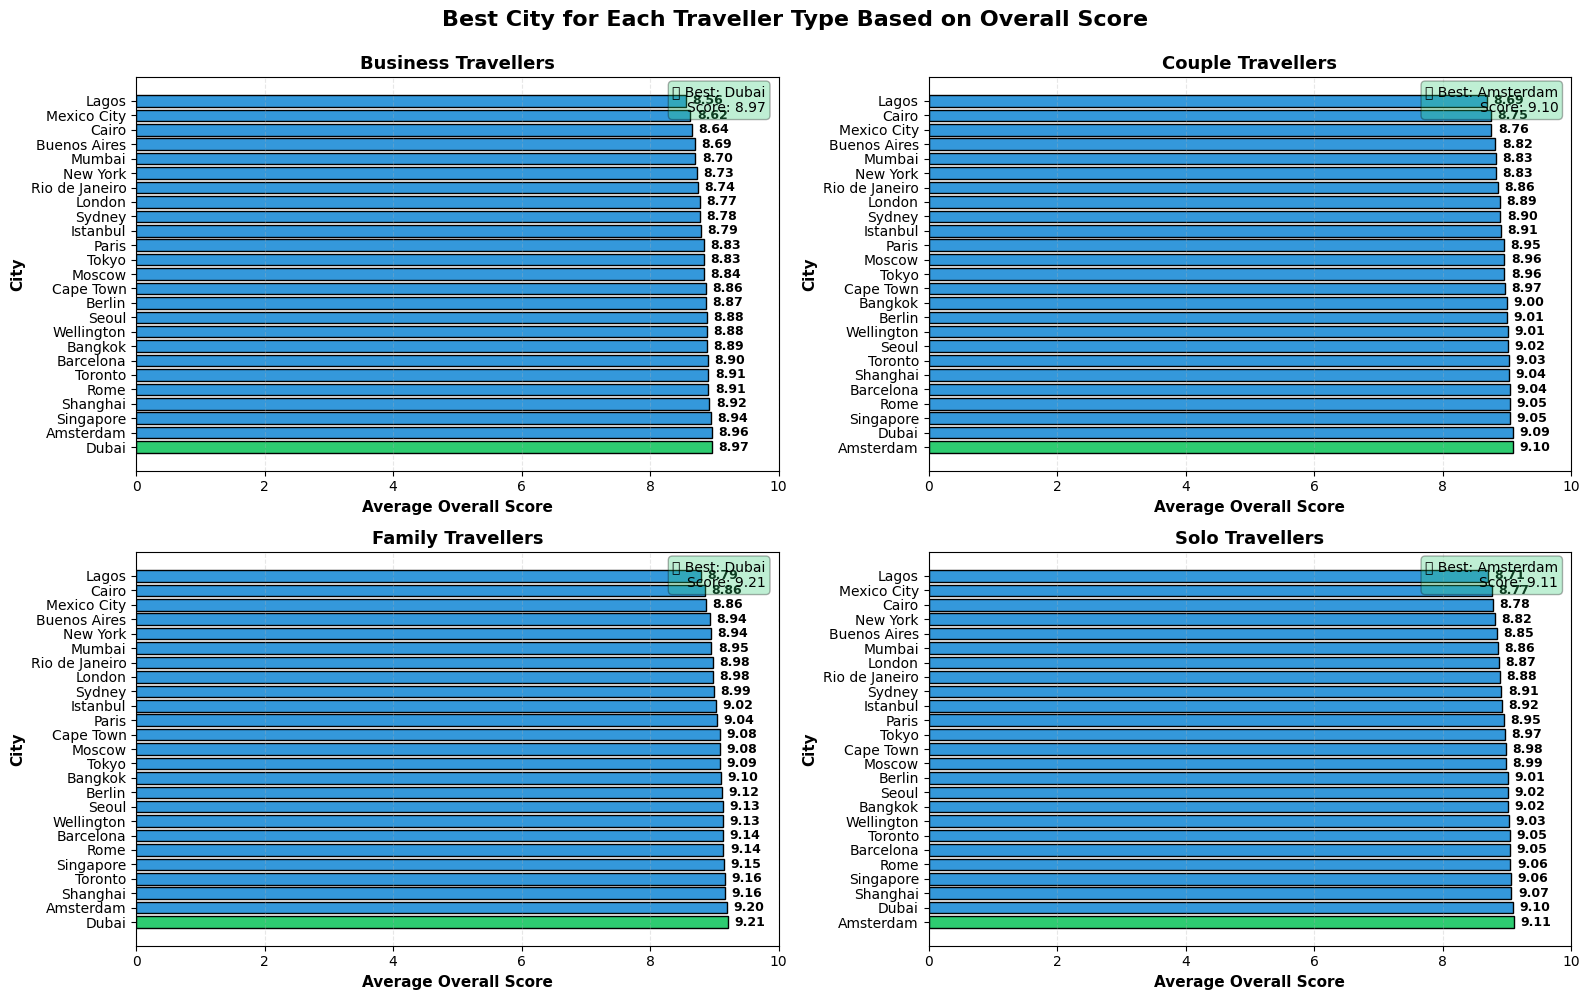

In [30]:

# OPTION 1: Grouped Bar Chart (One subplot per traveller type) - RECOMMENDED
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

traveller_types = city_scores['traveller_type'].unique()

for idx, traveller in enumerate(traveller_types):
    # Filter data for this traveller type
    data = city_scores[city_scores['traveller_type'] == traveller]
    best_city = best_cities[best_cities['traveller_type'] == traveller]['city'].values[0]
    
    # Create colors (highlight best city in green)
    colors = ['#2ECC71' if city == best_city else '#3498DB' for city in data['city']]
    
    # Plot horizontal bar chart
    axes[idx].barh(data['city'], data['score_overall'], color=colors, edgecolor='black', linewidth=1)
    axes[idx].set_xlabel('Average Overall Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('City', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{traveller} Travellers', fontsize=13, fontweight='bold')
    axes[idx].set_xlim(0, 10)
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add score labels on bars
    for i, (city, score) in enumerate(zip(data['city'], data['score_overall'])):
        axes[idx].text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9, fontweight='bold')
    
    # Add best city annotation
    best_score = best_cities[best_cities['traveller_type'] == traveller]['score_overall'].values[0]
    axes[idx].text(0.98, 0.98, f'🏆 Best: {best_city}\nScore: {best_score:.2f}',
                  transform=axes[idx].transAxes, fontsize=10, ha='right', va='top',
                  bbox=dict(boxstyle='round', facecolor='#2ECC71', alpha=0.3, edgecolor='black'))

plt.suptitle('Best City for Each Traveller Type Based on Overall Score', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

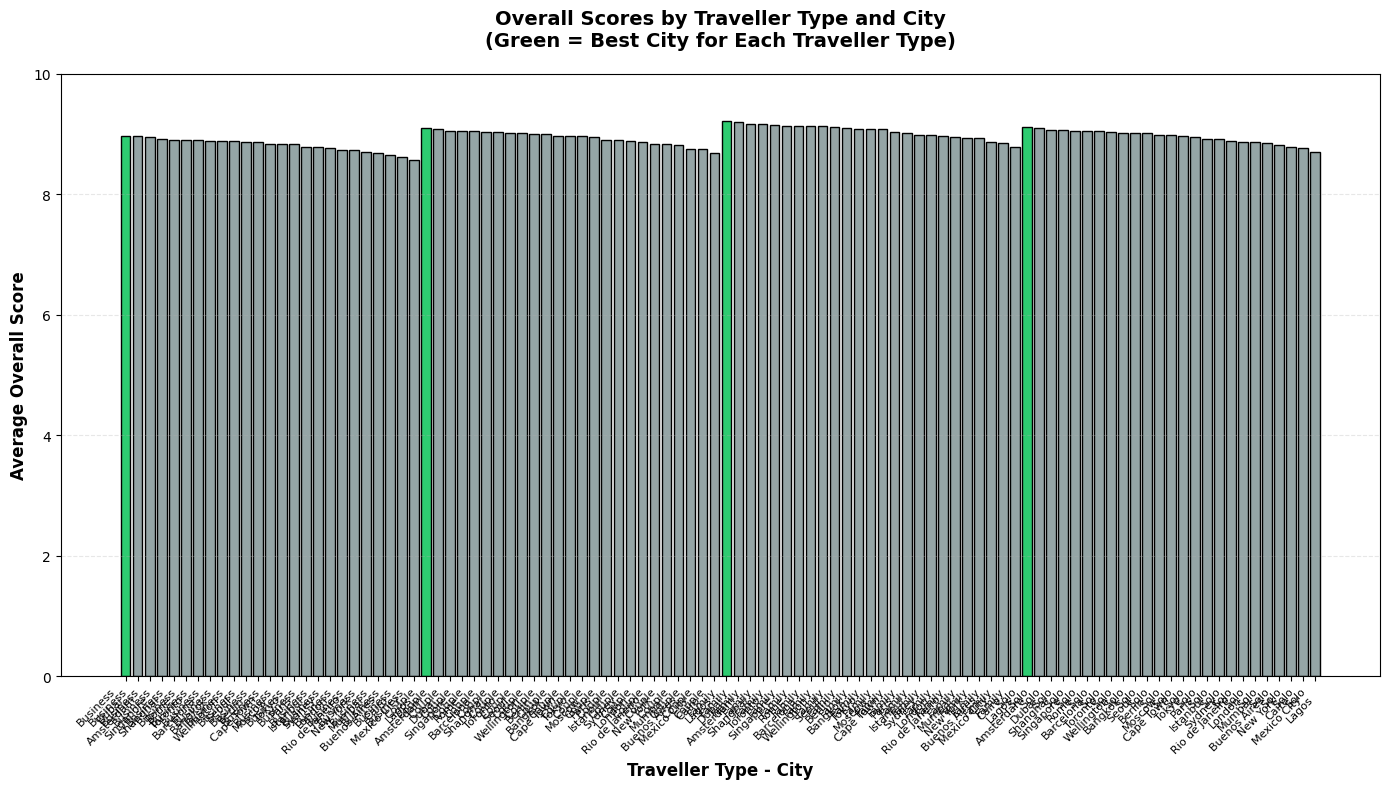

In [31]:
plt.figure(figsize=(14, 8))

# Create position for bars
traveller_list = []
city_list = []
score_list = []
color_list = []

for traveller in traveller_types:
    data = city_scores[city_scores['traveller_type'] == traveller]
    best_city = best_cities[best_cities['traveller_type'] == traveller]['city'].values[0]
    
    for _, row in data.iterrows():
        traveller_list.append(traveller)
        city_list.append(row['city'])
        score_list.append(row['score_overall'])
        color_list.append('#2ECC71' if row['city'] == best_city else '#95A5A6')

# Create grouped bar chart
x_labels = [f"{t}\n{c}" for t, c in zip(traveller_list, city_list)]
x_pos = range(len(x_labels))

plt.bar(x_pos, score_list, color=color_list, edgecolor='black', linewidth=1)
plt.xlabel('Traveller Type - City', fontsize=12, fontweight='bold')
plt.ylabel('Average Overall Score', fontsize=12, fontweight='bold')
plt.title('Overall Scores by Traveller Type and City\n(Green = Best City for Each Traveller Type)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(x_pos, x_labels, rotation=45, ha='right', fontsize=8)
plt.ylim(0, 10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


/var/folders/7q/s1qhvx8s7h7534p2wqfvy9t00000gn/T/ipykernel_1181/1789305309.py:33: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/macbookpro/Desktop/ACL/fire_env_tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


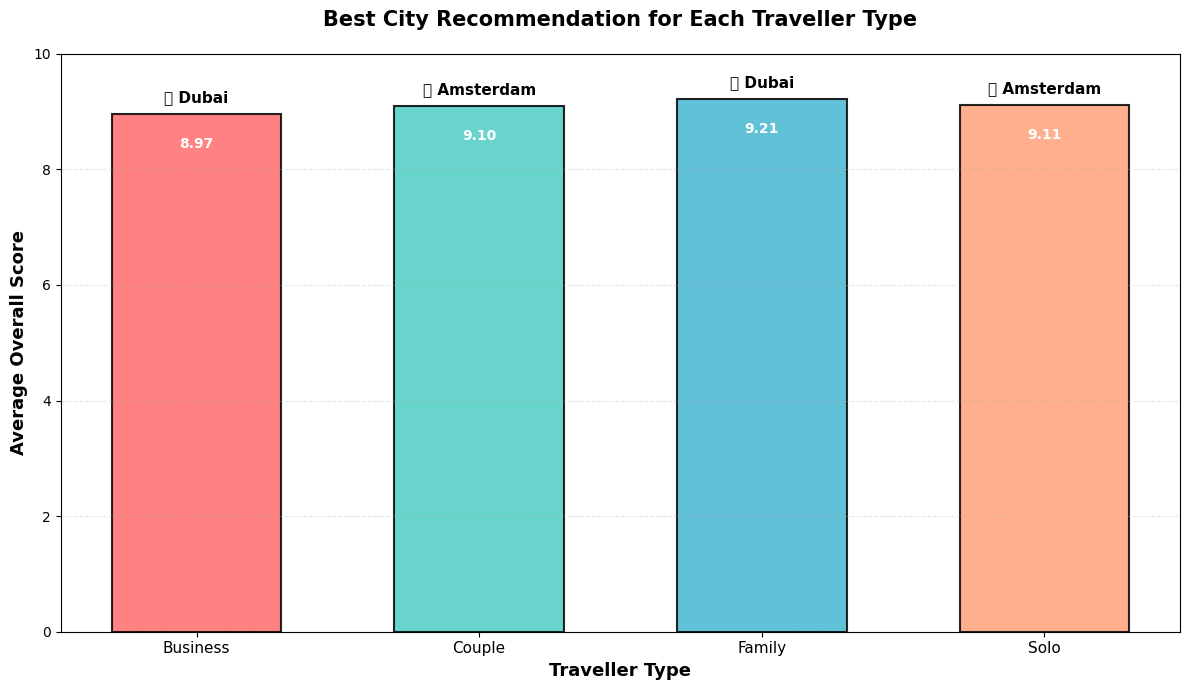


📊 BEST CITY RECOMMENDATIONS
Business        → Dubai                (Score: 8.97)
Couple          → Amsterdam            (Score: 9.10)
Family          → Dubai                (Score: 9.21)
Solo            → Amsterdam            (Score: 9.11)


In [32]:
plt.figure(figsize=(12, 7))

# Define colors for each traveller type
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Create bar chart
bars = plt.bar(best_cities['traveller_type'], 
               best_cities['score_overall'], 
               color=colors, 
               edgecolor='black', 
               linewidth=1.5, 
               alpha=0.85,
               width=0.6)

# Customize plot
plt.xlabel('Traveller Type', fontsize=13, fontweight='bold')
plt.ylabel('Average Overall Score', fontsize=13, fontweight='bold')
plt.title('Best City Recommendation for Each Traveller Type', 
          fontsize=15, fontweight='bold', pad=20)
plt.ylim(0, 10)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add city names and scores on top of each bar
for i, (traveller, city, score) in enumerate(zip(best_cities['traveller_type'], 
                                                   best_cities['city'], 
                                                   best_cities['score_overall'])):
    plt.text(i, score + 0.15, f'🏆 {city}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(i, score - 0.4, f'{score:.2f}', 
             ha='center', va='top', fontsize=10, fontweight='bold', color='white')

plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 BEST CITY RECOMMENDATIONS")
print("="*60)
for _, row in best_cities.iterrows():
    print(f"{row['traveller_type']:15} → {row['city']:20} (Score: {row['score_overall']:.2f})")

In [33]:
df = pd.get_dummies(df, columns=['traveller_type'], drop_first=True)
df = pd.get_dummies(df, columns=['city'], drop_first=True)
df = pd.get_dummies(df, columns=['user_gender'], drop_first=True)
age_order = {
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55+': 5
}

df['age'] = df['age_group'].map(age_order)
df.drop(columns=['age_group'], inplace=True)

In [34]:

from typing import final


columns_to_drop = [
    'review_id',         
    'user_id',           
    'hotel_id',          
    'review_date',      
    'join_date',          
    'user_country',     
    'review_text',       
    'hotel_name',        
    'hotel_country',      
    'lat',                
    'lon'  
]
final_df=df.drop(columns=columns_to_drop)

# final_df.to_csv('final_dataset.csv', index=False)   
final_df.head()


,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,star_rating,cleanliness_base,comfort_base,...,city_Seoul,city_Shanghai,city_Singapore,city_Sydney,city_Tokyo,city_Toronto,city_Wellington,user_gender_Male,user_gender_Other,age
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,5,9.1,8.8,...,False,False,False,False,False,False,False,False,False,2
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,5,9.6,9.0,...,False,False,False,False,True,False,False,False,False,3
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,5,8.8,8.7,...,False,False,False,False,False,False,False,False,False,5
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,5,9.2,9.1,...,False,False,False,False,False,False,False,False,False,3
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,5,9.1,9.3,...,False,False,False,False,False,False,False,True,False,4


In [35]:
final_df.isnull().sum()

score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
star_rating              0
cleanliness_base         0
comfort_base             0
facilities_base          0
location_base            0
staff_base               0
value_for_money_base     0
country_group            0
traveller_type_Couple    0
traveller_type_Family    0
traveller_type_Solo      0
city_Bangkok             0
city_Barcelona           0
city_Berlin              0
city_Buenos Aires        0
city_Cairo               0
city_Cape Town           0
city_Dubai               0
city_Istanbul            0
city_Lagos               0
city_London              0
city_Mexico City         0
city_Moscow              0
city_Mumbai              0
city_New York            0
city_Paris               0
city_Rio de Janeiro      0
city_Rome                0
city_Seoul               0
city_Shanghai            0
c

In [36]:
final_df.isnull().sum()
final_df.rename(columns={"age_encoded":"age","ci":"user_country"},inplace=True)

In [37]:
final_df.to_csv('final_dataset.csv', index=False)

final_df is the cleaned dataset 

In [42]:
X = final_df[['score_overall','score_cleanliness','score_comfort','score_facilities','score_location','score_staff','score_value_for_money','star_rating','cleanliness_base','comfort_base','facilities_base','location_base','staff_base','value_for_money_base','traveller_type_Couple','traveller_type_Family','traveller_type_Solo','city_Bangkok','city_Barcelona','city_Berlin','city_Buenos Aires','city_Cairo','city_Cape Town','city_Dubai','city_Istanbul','city_Lagos','city_London','city_Mexico City','city_Moscow','city_Mumbai','city_New York','city_Paris','city_Rio de Janeiro','city_Rome','city_Seoul','city_Shanghai','city_Singapore','city_Sydney','city_Tokyo','city_Toronto','city_Wellington','user_gender_Male','user_gender_Other','age' ]] 
y = final_df['country_group']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
log_model = LogisticRegression(
    max_iter=1000,
)

In [47]:
log_model.fit(X_train,y_train)

/Users/macbookpro/Desktop/ACL/fire_env_tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [52]:
y_pred = log_model.predict(X_test)

print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))

=== Logistic Regression Evaluation ===
Accuracy: 0.3393
Precision: 0.11512449
Recall: 0.3393
F1 Score: 0.17191740461435076

Detailed Report:
                       precision    recall  f1-score   support

              Africa       0.00      0.00      0.00       305
           East_Asia       0.00      0.00      0.00      1618
      Eastern_Europe       0.00      0.00      0.00       264
         Middle_East       0.00      0.00      0.00       469
       North_America       0.00      0.00      0.00      1935
North_America_Mexico       0.00      0.00      0.00       243
             Oceania       0.00      0.00      0.00       548
       South_America       0.00      0.00      0.00       631
          South_Asia       0.00      0.00      0.00       335
      Southeast_Asia       0.00      0.00      0.00       259
      Western_Europe       0.34      1.00      0.51      3393

            accuracy                           0.34     10000
           macro avg       0.03      0.09      0.0

/Users/macbookpro/Desktop/ACL/fire_env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbookpro/Desktop/ACL/fire_env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbookpro/Desktop/ACL/fire_env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # multi-class output
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("=== Neural Network Evaluation ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()